# Working with data 2017. Class 8
## Contact
Javier Garcia-Bernardo
garcia@uva.nl

## 1. Clustering
## 2. Data imputation
## 3. Dimensionality reduction


In [2]:
##Some code to run at the beginning of the file, to be able to show images in the notebook
##Don't worry about this cell

#Print the plots in this screen
%matplotlib inline 

#Be able to plot images saved in the hard drive
from IPython.display import Image 

#Make the notebook wider
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.formula.api as smf
import sklearn
from sklearn.model_selection import train_test_split


# 3. Dimensionality reduction
- Many times we want to combine variables (for linear regression to avoid multicollinearity, to create indexes, etc)




### Our data

In [3]:
#Read data
df_companies = pd.read_csv("data/big3_position.csv",sep="\t")
df_companies["log_revenue"] = np.log10(df_companies["Revenue"])
df_companies["log_assets"] = np.log10(df_companies["Assets"])
df_companies["log_employees"] = np.log10(df_companies["Employees"])
df_companies["log_marketcap"] = np.log10(df_companies["MarketCap"])

#Keep only industrial companies
df_companies = df_companies.loc[:,["log_revenue","log_assets","log_employees","log_marketcap","Company_name","TypeEnt"]]
df_companies = df_companies.loc[df_companies["TypeEnt"]=="Industrial company"]

#Dropnans
df_companies = df_companies.replace([np.inf,-np.inf],np.nan)
df_companies = df_companies.dropna()


df_companies.head()

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


,log_revenue,log_assets,log_employees,log_marketcap,Company_name,TypeEnt
23,3.634679,4.271609,1.633468,5.483054,"PROTEOSTASIS THERAPEUTICS, INC.",Industrial company
24,4.645913,5.266613,2.029384,5.488190,"TELIGENT, INC.",Industrial company
27,6.204633,6.168790,3.832509,6.906554,IDEXX LABORATORIES INC,Industrial company
32,7.469174,7.988933,4.201397,7.739554,CONOCOPHILLIPS,Industrial company
33,6.080771,6.175744,3.732394,6.037998,"ENPRO INDUSTRIES, INC.",Industrial company


**Correlation between variables**

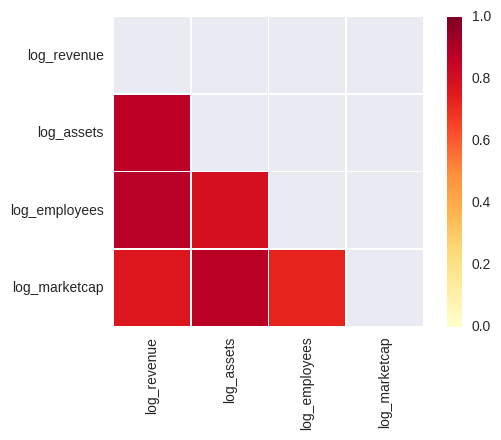

In [4]:
# Compute the correlation matrix
corr = df_companies.corr()

# Generate a mask for the upper triangle (hide the upper triangle)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, square=True,linewidths=.5,cmap="YlOrRd",vmin=0,vmax=1)

plt.show()

Revenue, employees and assets are highly correlated.

Let's imagine wwe want to explain the market capitalization in terms of the other variables. 

In [5]:
mod = smf.ols(formula='log_marketcap ~ log_revenue + log_employees  + log_assets', data=df_companies)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          log_marketcap   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     2773.
Date:                Thu, 02 Feb 2017   Prob (F-statistic):               0.00
Time:                        08:26:56   Log-Likelihood:                -1431.3
No. Observations:                2484   AIC:                             2871.
Df Residuals:                    2480   BIC:                             2894.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         0.7175      0.067     10.673

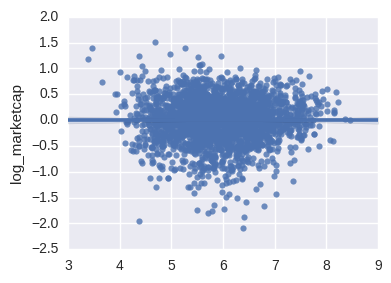

In [6]:
#The residuals are fine
plt.figure(figsize=(4,3))
sns.regplot(res.predict(),df_companies["log_marketcap"] -res.predict())

In [7]:
#Get many models to see hwo coefficient changes
from statsmodels.iolib.summary2 import summary_col

mod1 = smf.ols(formula='log_marketcap ~ log_revenue + log_employees  + log_assets', data=df_companies).fit()
mod2 = smf.ols(formula='log_marketcap ~ log_revenue + log_assets', data=df_companies).fit()
mod3 = smf.ols(formula='log_marketcap ~ log_employees  + log_assets', data=df_companies).fit()
mod4 = smf.ols(formula='log_marketcap ~ log_assets', data=df_companies).fit()

mod5 = smf.ols(formula='log_marketcap ~ log_revenue + log_employees ', data=df_companies).fit()
mod6 = smf.ols(formula='log_marketcap ~ log_revenue ', data=df_companies).fit()

mod7 = smf.ols(formula='log_marketcap ~ log_employees  ', data=df_companies).fit()

output = summary_col([mod1,mod2,mod3,mod4,mod5,mod6,mod7],stars=True)
print(mod1.rsquared_adj,mod2.rsquared_adj,mod3.rsquared_adj,mod4.rsquared_adj,mod5.rsquared_adj,mod6.rsquared_adj,mod7.rsquared_adj)
output

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

0.770085449982 0.768229760717 0.769633653357 0.768295907742 0.602303466161 0.591747385198 0.529313920375


,log_marketcap I,log_marketcap II,log_marketcap III,log_marketcap IIII,log_marketcap IIIII,log_marketcap IIIIII,log_marketcap IIIIIII
Intercept,0.7175***,0.5808***,0.6901***,0.5758***,2.4392***,2.1779***,3.6642***
,(0.0672),(0.0605),(0.0663),(0.0598),(0.0706),(0.0638),(0.0449)
log_assets,0.8800***,0.8935***,0.8505***,0.9032***,,,
,(0.0207),(0.0205),(0.0167),(0.0100),,,
log_employees,0.0912***,,0.0612***,,0.2117***,,0.7000***
,(0.0199),,(0.0156),,(0.0259),,(0.0132)
log_revenue,-0.0524**,0.0092,,,0.4906***,0.6563***,
,(0.0216),(0.0170),,,(0.0230),(0.0109),


## 3.1 Combining variables
- Multiplying/summing variables 
- It's easy
- It's arbitrary

In [8]:
X = df_companies.loc[:,["log_revenue","log_employees","log_assets"]]
X.head(2)

,log_revenue,log_employees,log_assets
23,3.634679,1.633468,4.271609
24,4.645913,2.029384,5.266613


In [9]:
#Let's scale all the columns to have mean 0 and std 1
from sklearn.preprocessing import scale
X_to_combine = scale(X)
X_to_combine

array([[-1.99571299, -1.73647635, -1.91571154],
       [-1.03556037, -1.31257881, -0.77455883],
       [ 0.44442179,  0.61798627,  0.26013323],
       ..., 
       [ 0.93584733,  1.17438899,  0.59298665],
       [-0.87417016, -0.80028962, -1.19760982],
       [-0.07417925,  0.82440959, -0.64435546]])

In [10]:
#In this case we sum them together
X_combined = np.sum(X_to_combine,axis=1)
X_combined

array([-5.64790088, -3.12269802,  1.32254129, ...,  2.70322297,
       -2.8720696 ,  0.10587488])

In [11]:
#Add a new column with our combined variable and run regression
df_companies["combined"] = X_combined
print(smf.ols(formula='log_marketcap ~ combined  ', data=df_companies).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          log_marketcap   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     5617.
Date:                Thu, 02 Feb 2017   Prob (F-statistic):               0.00
Time:                        08:26:58   Log-Likelihood:                -1789.8
No. Observations:                2484   AIC:                             3584.
Df Residuals:                    2482   BIC:                             3595.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.9428      0.010    595.258      0.0

## 3.2 PCA
- Keep all the info
- The resulting variables do not actually mean much

In [12]:
#Do the fitting
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

print("Explained variance")
print(pca.explained_variance_ratio_)
print()

print("Weight of components")
print(["log_revenue","log_employees","log_assets"])
print(pca.components_)
print()

new_X

Explained variance
[ 0.90754131  0.05796448]

Weight of components
['log_revenue', 'log_employees', 'log_assets']
[[-0.65102557 -0.55826228 -0.51430431]
 [ 0.04059483 -0.70219538  0.71082608]]



array([[ 3.13287507, -0.13380895],
       [ 1.74177643,  0.33650637],
       [-0.74360056, -0.22507263],
       ..., 
       [-1.51992984, -0.36267534],
       [ 1.55371598, -0.25477687],
       [-0.0900414 , -0.9432188 ]])

In [13]:
#Create our new variables (2 components, so 2 variables)
df_companies["pca_x1"] = new_X[:,0]
df_companies["pca_x2"] = new_X[:,1]

In [14]:
print(smf.ols(formula='log_marketcap ~ pca_x1 + pca_x2 ', data=df_companies).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          log_marketcap   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     3545.
Date:                Thu, 02 Feb 2017   Prob (F-statistic):               0.00
Time:                        08:26:59   Log-Likelihood:                -1581.7
No. Observations:                2484   AIC:                             3169.
Df Residuals:                    2481   BIC:                             3187.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.9428      0.009    647.146      0.0

Before


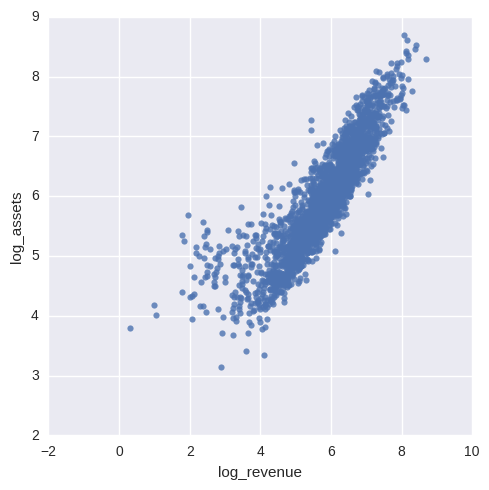

In [15]:
print("Before")
sns.lmplot("log_revenue","log_assets",data=df_companies,fit_reg=False)

After


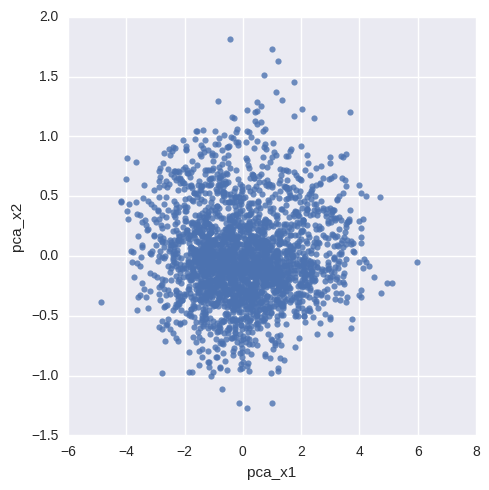

In [16]:
print("After")
sns.lmplot("pca_x1","pca_x2",data=df_companies,fit_reg=False)

## 3.3 Factor analysis
- The observations are assumed to be caused by a linear transformation of lower dimensional latent factors and added Gaussian noise. Without loss of generality the factors are distributed according to a Gaussian with zero mean and unit covariance. The noise is also zero mean and has an arbitrary diagonal covariance matrix.

In [43]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=2)
new_X = fa.fit_transform(X)

print("Weight of components")
print(["log_revenue","log_employees","log_assets"])
print(fa.components_)
print()

new_X

Weight of components
['log_revenue', 'log_employees', 'log_assets']
[[-1.01579117 -0.85478902 -0.79054836]
 [ 0.00155853 -0.143005    0.14338296]]



array([[ 1.95803243, -0.16050885],
       [ 1.06995109,  0.43027854],
       [-0.45630827, -0.28772932],
       ..., 
       [-0.93899904, -0.4656501 ],
       [ 0.9512708 , -0.32753938],
       [-0.0206818 , -1.19533099]])

In [44]:
#New variables
df_companies["fa_x1"] = new_X[:,0]
df_companies["fa_x2"] = new_X[:,1]

In [45]:
print(smf.ols(formula='log_marketcap ~ fa_x1  + fa_x2 ', data=df_companies).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          log_marketcap   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     3359.
Date:                Thu, 02 Feb 2017   Prob (F-statistic):               0.00
Time:                        08:21:02   Log-Likelihood:                -1631.1
No. Observations:                2484   AIC:                             3268.
Df Residuals:                    2481   BIC:                             3286.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.9428      0.009    634.407      0.0

After


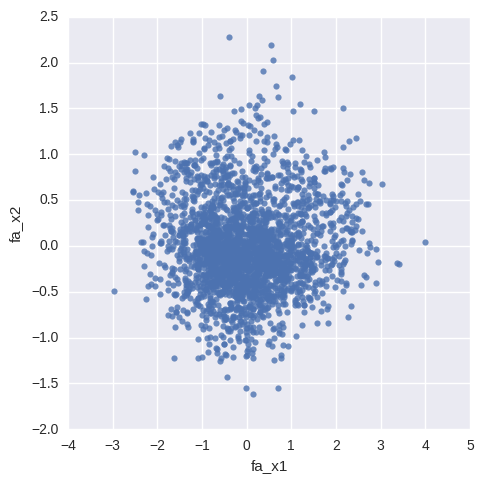

In [46]:
print("After")
sns.lmplot("fa_x1","fa_x2",data=df_companies,fit_reg=False)

### Difference between FA and PCA
http://stats.stackexchange.com/questions/1576/what-are-the-differences-between-factor-analysis-and-principal-component-analysi

- Principal component analysis involves extracting linear composites of observed variables.
- Factor analysis is based on a formal model predicting observed variables from theoretical latent factors.

# 3.4 Methods to avoid overfitting (Machine learning with regularization)
- SVR: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
- Lasso regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Both have a regularization parameter, that penalizes having many terms. How to choose the best value of this parameter?
- With a train_test split (or cross-validation)
    - http://scikit-learn.org/stable/modules/cross_validation.html
    - http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [47]:
Image(url="http://www.holehouse.org/mlclass/07_Regularization_files/Image.png")

In [19]:
from sklearn.model_selection import train_test_split
y = df_companies["log_marketcap"]
X = df_companies.loc[:,["log_revenue","log_employees","log_assets"]]
X.head(2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.head()

,log_revenue,log_employees,log_assets
836,6.455242,4.285557,6.615582
189,5.075985,2.655138,5.081912
1911,7.286230,4.431364,6.876073
3858,5.644867,2.518514,6.168640
1809,6.883773,4.181844,6.284532


**Linear regression (to compare)**

In [25]:
df_train = X_train.copy()
df_train["log_marketcap"] = y_train
df_train.head()

mod = smf.ols(formula='log_marketcap ~ log_revenue + log_employees  + log_assets', data=df_train).fit()
print("log_revenue 	log_employees 	log_assets ")
print(mod.params.values[1:])



log_revenue 	log_employees 	log_assets 
[-0.0745411   0.09301402  0.90935025]


**SVR**
- Gives balanced weights (the most correlated independent variable (with the dependent) doesn't take all the weight).
- Very good when you have hundreds of variables. You can iteratively drop the worst predictor.
- It allow for more than linear "regression". The default kernel is "rbf", which fits curves. The problem is that interpreting it is hard.

In [56]:
from sklearn.svm import SVR
clf = SVR(C=0.1, epsilon=0.2,kernel="linear")
clf.fit(X_train, y_train) 

print("log_revenue 	log_employees 	log_assets ")
print(clf.coef_)


log_revenue 	log_employees 	log_assets 
[[-0.09292941  0.11011615  0.91769297]]


**Lasso**
- Have a penalty
- Discards the variables with low weights.

In [53]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.01)
reg.fit(X_train,y_train)

print("log_revenue 	log_employees 	log_assets ")
print(reg.coef_)


log_revenue 	log_employees 	log_assets 
[-0.          0.04451499  0.85993465]


**Summary**

In [57]:
print(["SVR","Lasso","Linear regression"])
err1,err2,err3 = sklearn.metrics.mean_squared_error(clf.predict(X_test),y_test),sklearn.metrics.mean_squared_error(reg.predict(X_test),y_test),sklearn.metrics.mean_squared_error(mod.predict(X_test),y_test)
print(err1,err2,err3)

['SVR', 'Lasso', 'Linear regression']
0.19001609378 0.18711028571 0.188061519375


In [58]:
print(["SVR","Lasso","Linear regression"])
err1,err2,err3 = sklearn.metrics.r2_score(clf.predict(X_test),y_test),sklearn.metrics.r2_score(reg.predict(X_test),y_test),sklearn.metrics.r2_score(mod.predict(X_test),y_test)
print(err1,err2,err3)

['SVR', 'Lasso', 'Linear regression']
0.694444205162 0.688371093093 0.695033719486
